# 영화 추천시스템 알고리즘



In [1]:
# 필수 라이브러리 import
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import pandas_datareader as pdr
from datetime import date
import re

In [2]:
# 그림 예쁘게
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=16)
mpl.rc('xtick', labelsize=16)
mpl.rc('ytick', labelsize=16)
mpl.rc('font', size=16)
plt.rc('legend', fontsize=16) 

# 한글 폰트 문제
plt.rcParams['axes.unicode_minus'] = False

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(14,8)})

In [3]:
# 한글 표기 문제 해결
!apt -qq -y install fonts-nanum > /dev/null
import matplotlib.font_manager as fm
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)

from plotnine import *
import plotnine

# 기본 글꼴 변경
import matplotlib as mpl
mpl.font_manager._rebuild()
mpl.pyplot.rc('font', family='NanumBarunGothic')

In [4]:
!pip3 install konlpy
from konlpy.tag import Okt

In [5]:
# 파일 불러오기(7740개의 영화 줄거리)
df = pd.read_csv('/content/drive/MyDrive/recommend_system/data.csv')
df_target = df.copy()
df_target.tail(10)


,id,title,overview
7730,878962,내 친구 샤크독: 파닥파닥 판타스틱 핼러윈,사탕 안주면 장난칠 거야! 핼러윈을 준비하며 잔뜩 신이 난 맥스. 이웃집을 돌기 전...
7731,883648,리틀 빅 마우스,밴드에서 쫓겨나 떠돌이가 된 기타리스트. 우여곡절 끝에 싱글 맘의 집에서 신세를 진...
7732,885110,아미나: 전사의 이름,지금은 나이지리아의 자리아라 불리는 곳. 16세기 자자우에서 공주 아미나가 왕국을 ...
7733,887645,완벽에서 살짝 모자란,"이혼한 변호사 이바나, 카리스마 넘치는 심장 전문의와 사랑에 빠진다. 그런데 남자의..."
7734,888910,사서함 1142: 미국의 비밀 나치 수용소,2차대전 참전 군인들의 증언을 통해 미국 내 비밀 군부대의 정체를 파헤친 단편 애니...
7735,888917,사기의 제왕,그들에게 탄소는 황금보다 빛났다. 오염물질 배출권 거래 제도를 이용해 막대한 돈을 ...
7736,889300,러브 미 인스테드,"딸과 재회하고 비로소 화해하고 싶은 죄수. 교도관과 함께 고향으로 여행을 떠나지만,..."
7737,892342,행복이여 영원하라,《Happiness is a Four-Letter Word》가 속편으로 돌아왔다. ...
7738,895571,당신은 학생인가,왜 우리가 하는 공부는 고통스러울까? 질문에 답변하기 위해 갓 수능을 마친 학생들이...
7739,897429,All Too Well: The Short Film,테일러 스위프트의 정규 6집 재녹음 앨범 Red의 수록곡 All Too Well의 ...


In [6]:
print(df_target.isnull().sum())

id          0
title       0
overview    0
dtype: int64


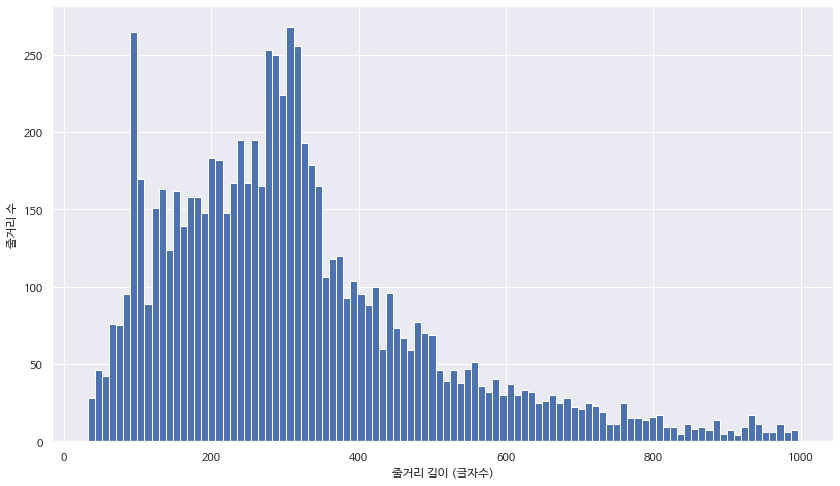

count    7740.000000
mean      315.844961
std       182.069410
min        32.000000
25%       186.000000
50%       287.000000
75%       396.250000
max       996.000000
Name: overview, dtype: float64


In [7]:
# 줄거리 길이 분포 확인

overview_length = df_target.overview.astype(str).apply(len)

plt.hist(overview_length, bins=100)
plt.xlabel('줄거리 길이 (글자수)')
plt.ylabel('줄거리 수')

plt.show()

print(overview_length.describe())

In [8]:
# 정규 표현식 적용(한글, 숫자, 영어 빼고 전부 제거)
def sub_ex(s):
  return re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣0-9a-zA-Z ]','',s)

# def sub_ex(s):
#   return re.sub(r'[^0-9a-zA-Z ]','',s)

df_target.loc[:,'overview'] = df_target.loc[:,'overview'].apply(sub_ex)

df_target.tail(10)

,id,title,overview
7730,878962,내 친구 샤크독: 파닥파닥 판타스틱 핼러윈,사탕 안주면 장난칠 거야 핼러윈을 준비하며 잔뜩 신이 난 맥스 이웃집을 돌기 전에 ...
7731,883648,리틀 빅 마우스,밴드에서 쫓겨나 떠돌이가 된 기타리스트 우여곡절 끝에 싱글 맘의 집에서 신세를 진다...
7732,885110,아미나: 전사의 이름,지금은 나이지리아의 자리아라 불리는 곳 16세기 자자우에서 공주 아미나가 왕국을 지...
7733,887645,완벽에서 살짝 모자란,이혼한 변호사 이바나 카리스마 넘치는 심장 전문의와 사랑에 빠진다 그런데 남자의 키...
7734,888910,사서함 1142: 미국의 비밀 나치 수용소,2차대전 참전 군인들의 증언을 통해 미국 내 비밀 군부대의 정체를 파헤친 단편 애니...
7735,888917,사기의 제왕,그들에게 탄소는 황금보다 빛났다 오염물질 배출권 거래 제도를 이용해 막대한 돈을 챙...
7736,889300,러브 미 인스테드,딸과 재회하고 비로소 화해하고 싶은 죄수 교도관과 함께 고향으로 여행을 떠나지만 비...
7737,892342,행복이여 영원하라,Happiness is a FourLetter Word가 속편으로 돌아왔다 자자 프...
7738,895571,당신은 학생인가,왜 우리가 하는 공부는 고통스러울까 질문에 답변하기 위해 갓 수능을 마친 학생들이 ...
7739,897429,All Too Well: The Short Film,테일러 스위프트의 정규 6집 재녹음 앨범 Red의 수록곡 All Too Well의 ...


In [9]:
# 불용어 리스트
STOP_WORDS = ['영화', '이야기', '의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 형태소 분석
okt = Okt()
def morph_and_stopword(s):
  token_lst = []
  tmp = okt.morphs(s, stem=True)

  #불용어 처리
  for token in tmp:
    if token not in STOP_WORDS:
      token_lst.append(token)


### TF-IDF (Term Frequency-Inverse Document Frequency)

- 어떤 문서가 특정 주제를 다룰 경우 해당 주제와 관련된 단어 또는 단어의 조합이 자주 등장함 $\rightarrow$ TF (Term Frequency)
- 빈도가 높은 단어라도 모든 문서에 흔히 등장하는 경우 낮은 가중치를 부여 $\rightarrow$ IDF (Inverse Term Frequency)
- 예: 경제와 관련된 문헌의 경우 '경제'란 용어가 공통적으로 많이 등장하므로 출현 빈도에 비해 중요도를 낮게 책정
- TF-IDF 산식:
\begin{equation}
f(\log(\frac{N}{n}) + 1)
\end{equation}

  - f = 특정 단어가 어떤 문서 D에서 출현한 회수
  - N = 문서의 총 개수
  - n = N건의 문서 중 특정 단어가 출현한 회수

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF 생성
tfidf = TfidfVectorizer()
tfidf_matrix = tfidf.fit_transform(df.overview)

# 줄거리에 대해서 tf-idf 수행
print(tfidf_matrix.shape)

(7740, 130190)


**코사인 유사도(Cosine Similarity)**

- 코사인 유사도는 거리는 보지 않고, 두 벡터의 방향만 측정함.
- 같은 방향이면 1, 정반대 방향이면 -1, 서로 독립적이라면 0이 나옴. 

\begin{equation}
similarity(A,B) = cos(\theta)=\frac{A \cdot B}{\parallel A \parallel \parallel B \parallel} = \frac{\Sigma_{i=1}^{n}a_{i}b_{i}}{\sqrt{\Sigma_{i=1}^{n}a_{i}^{2}}\sqrt{\Sigma_{i=1}^{n}b_{i}^{2}}}
\end{equation}

In [11]:
from sklearn.metrics.pairwise import linear_kernel
cosine_result = linear_kernel(tfidf_matrix, tfidf_matrix)

In [12]:
cosine_result

array([[1.        , 0.00231689, 0.00968076, ..., 0.        , 0.00593123,
        0.        ],
       [0.00231689, 1.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00968076, 0.        , 1.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 1.        , 0.01744659,
        0.        ],
       [0.00593123, 0.        , 0.        , ..., 0.01744659, 1.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        1.        ]])

In [13]:
indices_title = pd.Series(df.index, index=df.title).drop_duplicates()
print(indices_title)

title
아리엘                                0
포룸                                 1
스타워즈: 에피소드 4 새로운 희망                2
니모를 찾아서                            3
포레스트 검프                            4
                                ... 
사기의 제왕                          7735
러브 미 인스테드                       7736
행복이여 영원하라                       7737
당신은 학생인가                        7738
All Too Well: The Short Film    7739
Length: 7740, dtype: int64


In [14]:
def movie_rec_title(title, cosine_matrix=cosine_result):
    """
    타이틀을 입력받아 영화를 추천해줍니다.
    """

    #입력한 영화로 부터 인덱스 가져오기
    idx = indices_title[title]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구하기
    rec_scores = list(enumerate(cosine_matrix[idx]))

    # 유사도에 따라 영화들을 정렬
    rec_scores = sorted(rec_scores, key=lambda x:x[1], reverse = True)

    # 가장 유사한 10개의 영화를 받아옴
    rec_scores = rec_scores[1:11]

    # 가장 유사한 10개 영화의 인덱스 받아옴
    movie_indices = [i[0] for i in rec_scores]
    
    #기존에 읽어들인 데이터에서 해당 인덱스의 값들을 가져온다. 그리고 스코어 열을 추가하여 코사인 유사도도 확인할 수 있게 한다.
    result_df = df.iloc[movie_indices].copy()
    result_df['score'] = [i[1] for i in rec_scores]
    
    # 읽어들인 데이터에서 줄거리 부분만 제거, 제목과 스코어만 보이게 함
    del result_df['overview']

    # 가장 유사한 10개의 영화의 제목을 리턴
    return result_df

In [24]:
movie_rec_title('스타워즈: 에피소드 4 새로운 희망')

,id,title,score
5428,330459,로그 원: 스타워즈 스토리,0.075434
6900,537788,다니엘 이즌 리얼,0.064196
3827,47933,인디펜던스 데이: 리써전스,0.051165
747,1891,스타워즈: 에피소드 5 제국의 역습,0.048879
4344,100042,덤 앤 더머 투,0.048184
4524,140607,스타워즈: 깨어난 포스,0.045535
4842,227719,백 투 더 비기닝,0.044001
3472,28510,유니버셜 솔저 3: 리제너레이션,0.043913
7538,732670,레고 스타워즈 홀리데이 스페셜,0.040411
7072,575604,콜,0.039119



그렇다면 이제 우리의 db에 저장해주기 위해 id 기반으로 데이터를 생성하겠습니다.


In [16]:
indices = pd.Series(df.index, index=df.id)
print(indices)

id
2            0
5            1
11           2
12           3
13           4
          ... 
888917    7735
889300    7736
892342    7737
895571    7738
897429    7739
Length: 7740, dtype: int64


In [17]:
def movie_rec(id, cosine_matrix=cosine_result):
    """
    db에 저장하기 위해 영화의 id로부터 추천 id를 반환합니다. 
    """

    #입력한 영화로 부터 인덱스 가져오기
    idx = indices[id]

    # 모든 영화에 대해서 해당 영화와의 유사도를 구하기
    rec_scores = list(enumerate(cosine_matrix[idx]))

        
    # 유사도에 따라 영화들을 정렬
    rec_scores = sorted(rec_scores, key=lambda x:x[1], reverse = True)

    # 가장 유사한 10개의 영화를 받아옴
    rec_scores = rec_scores[1:11]

    # 가장 유사한 10개 영화의 인덱스 받아옴
    movie_indices = [i[0] for i in rec_scores]
    
    #기존에 읽어들인 데이터에서 해당 인덱스의 값들을 가져온다.
    result_df = df.iloc[movie_indices].copy()
    result_df['score'] = [i[1] for i in rec_scores]
    
    # 읽어들인 데이터에서 줄거리 부분만 제거, 제목과 스코어만 보이게 함
    del result_df['overview']
    del result_df['score']

    # 가장 유사한 10개의 영화의 제목을 리턴
    return result_df

In [18]:
movie_rec(13)

,id,title
6126,428125,너와 100번째 사랑
5494,336804,무스탕: 랄리의 여름
6385,458302,레미: 집 없는 아이
2901,14306,말리와 나
5271,301351,위아 유어 프렌즈
3111,17332,솔로이스트
1283,7980,러블리 본즈
2928,14564,링스
721,1791,피아니스트
5159,286519,보이콰이어




json의 형태로 저장해주기 위해 딕셔너리 형태로 만들어줍니다.



In [19]:
result_dict = {}

for id in df.id:
  result_dict[id] = list(movie_rec(id).id)

print(result_dict)

{2: [508442, 5549, 12620, 8010, 733156, 348350, 11246, 427900, 38842, 333667], 5: [15582, 11888, 14444, 73723, 12102, 72105, 381283, 1649, 5175, 813], 11: [330459, 537788, 47933, 1891, 100042, 140607, 227719, 28510, 732670, 575604], 12: [10555, 59963, 578, 445651, 1634, 403119, 19908, 438970, 12429, 440762], 13: [428125, 336804, 458302, 14306, 301351, 17332, 7980, 14564, 1791, 286519], 14: [6557, 588, 33408, 568091, 183662, 19913, 14844, 458109, 13683, 10242], 15: [9516, 550412, 49948, 5820, 733156, 76757, 11457, 9558, 502167, 429422], 16: [1649, 615761, 9611, 501979, 546, 760883, 616651, 2898, 16642, 2124], 18: [10196, 760873, 9460, 228161, 323660, 339, 95, 28032, 72387, 512025], 19: [22383, 8438, 262543, 385317, 497916, 493922, 255343, 13474, 340382, 137227], 20: [11457, 1412, 26820, 7350, 12187, 238615, 419478, 410199, 447362, 45156], 22: [58, 1865, 10975, 19576, 426284, 60293, 321612, 16258, 11811, 438145], 24: [393, 74998, 43947, 465109, 871964, 10727, 810731, 2487, 454650, 25239]

In [20]:
import pickle

with open('recommendations.p', 'wb') as file:
    recommendations = pickle.dump(result_dict, file)

출처: https://blog.naver.com/PostList.naver?blogId=myincizor&from=postList&categoryNo=6